In [81]:
import pandas as pd;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../k6/results/run-2/ssrh/'

def convert_to_MiB(value):
    if 'GiB' in value:
        return str(int(float(value.replace('GiB', '')) * 1024))
    if 'MiB' in value:
        return value.replace('MiB', '')
    return value

def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

def graph_row(plot_func, datasets, height=3, width=20):
    cols = len(datasets)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, (name, dataset) in enumerate(datasets.items()):
        plot_func(dataset, axes[x], idx=x)
        axes[x].set_title(name)
    return plt

In [82]:
features = ['cpu_percent','mem_usage','mem_limit','mem_percent']
services = ["monolith", "recommendations", "teasers", "cdn", "discovery"]

df = pd.read_csv(f'{path}docker.csv', skiprows=1, names=['timestamp','name','cpu_percent','mem_usage','mem_limit','mem_percent'], sep=',')

df['mem_usage'] = df['mem_usage'].apply(convert_to_MiB).astype(float)
df['mem_limit'] = df['mem_limit'].apply(convert_to_MiB).astype(float)

df['cpu_percent'] = df['cpu_percent'].astype(float)
df['mem_percent'] = df['mem_percent'].astype(float)

start_time = df['timestamp'].min() + 120    # Warmup
end_time = df['timestamp'].max() - 30       # Cooldown
df_filtered = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]

dirty_dfs = {service: df_filtered[df_filtered["name"] == service].reset_index(drop=True) for service in services}

dirty_dfs['monolith'].describe()

,timestamp,cpu_percent,mem_usage,mem_limit,mem_percent
count,96.00,96.00,96.00,96.00,96.00
mean,1735068684.44,107.30,3302.77,4096.00,80.65
std,140.03,4.13,306.07,0.00,7.47
min,1735068446.00,103.81,2771.00,4096.00,67.67
25%,1735068564.75,104.61,3045.75,4096.00,74.38
50%,1735068684.50,105.92,3305.00,4096.00,80.70
75%,1735068804.25,107.90,3561.25,4096.00,86.96
max,1735068923.00,124.22,3822.00,4096.00,93.32


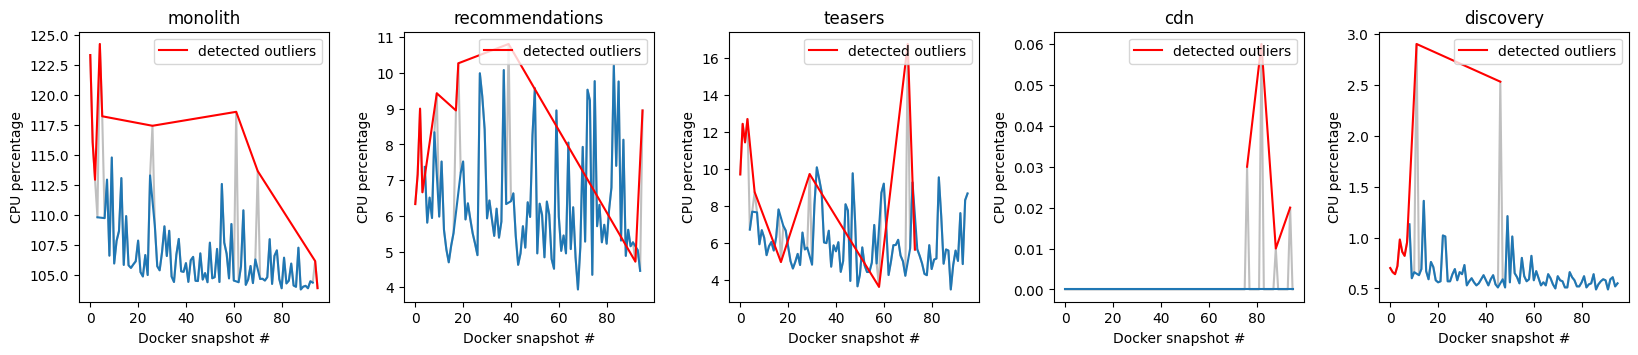

In [83]:
def plot_outliers(_df, d, loc, mask):
    loc.plot(_df['cpu_percent'], color='gray', alpha=0.5)
    loc.plot(_df['cpu_percent'][mask[d]])
    loc.plot(_df['cpu_percent'][~mask[d]], label='detected outliers', color='red')

    loc.set_title(d)
    loc.set_ylabel(f'CPU percentage') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

masks = {}
dfs = {}

for name, _df in dirty_dfs.items():
    mask = detect_outliers(_df, features)
    masks[name] = mask
    dfs[name] = _df[mask].copy()

graph_row(lambda _ds, loc, idx: plot_outliers(_ds, list(dfs.keys())[idx], loc, masks), dirty_dfs)
plt.show()

In [84]:
dfs['monolith'].describe()

,timestamp,cpu_percent,mem_usage,mem_limit,mem_percent
count,86.00,86.00,86.00,86.00,86.00
mean,1735068691.27,106.35,3318.20,4096.00,81.02
std,131.12,2.39,285.84,0.00,6.98
min,1735068461.00,103.81,2808.00,4096.00,68.56
25%,1735068582.25,104.55,3083.25,4096.00,75.28
50%,1735068689.50,105.75,3313.50,4096.00,80.91
75%,1735068806.75,107.15,3565.75,4096.00,87.06
max,1735068913.00,114.78,3802.00,4096.00,92.83


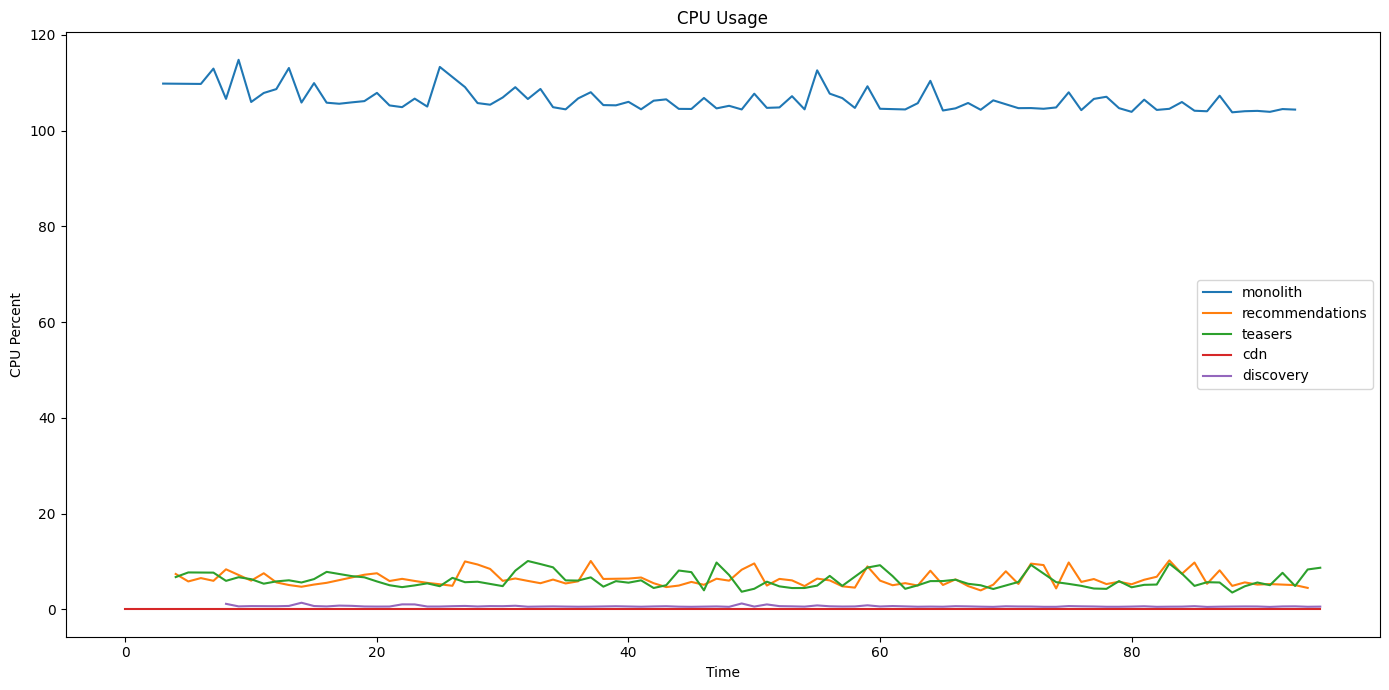

In [85]:
fig, ax = plt.subplots(figsize=(14, 7))

# CPU usage line graph
for s in services:
    ax.plot(dfs[s]['cpu_percent'], label=s)
ax.set_title('CPU Usage')
ax.set_xlabel('Time')
ax.set_ylabel('CPU Percent')
ax.legend()

plt.tight_layout()
plt.show()

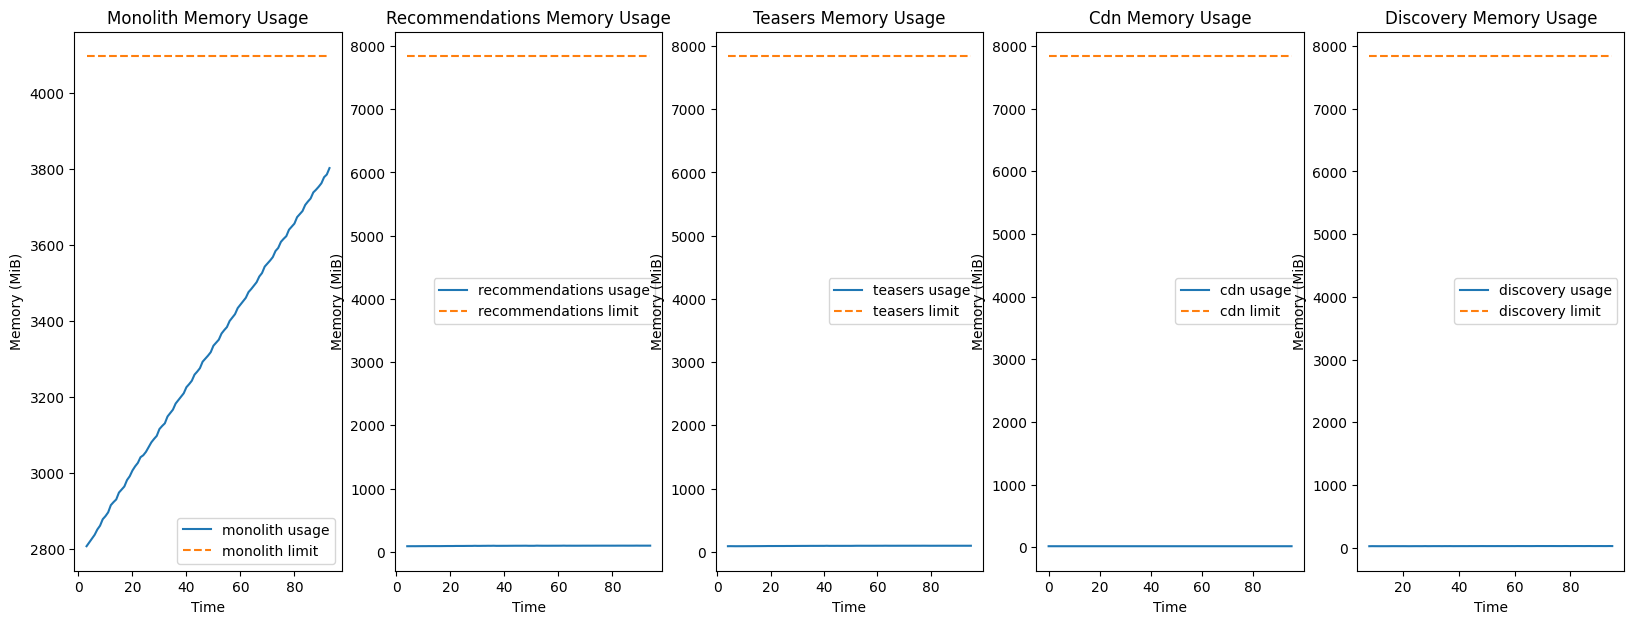

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=len(services), figsize=(20, 7))

# Memory usage line graph
for i, s in enumerate(services):
    axes[i].plot(dfs[s]['mem_usage'], label=f'{s} usage')
    axes[i].plot(dfs[s]['mem_limit'], linestyle='--', label=f'{s} limit')
    axes[i].set_title(f'{s.capitalize()} Memory Usage')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Memory (MiB)')
    axes[i].legend()

# plt.tight_layout()
plt.show()


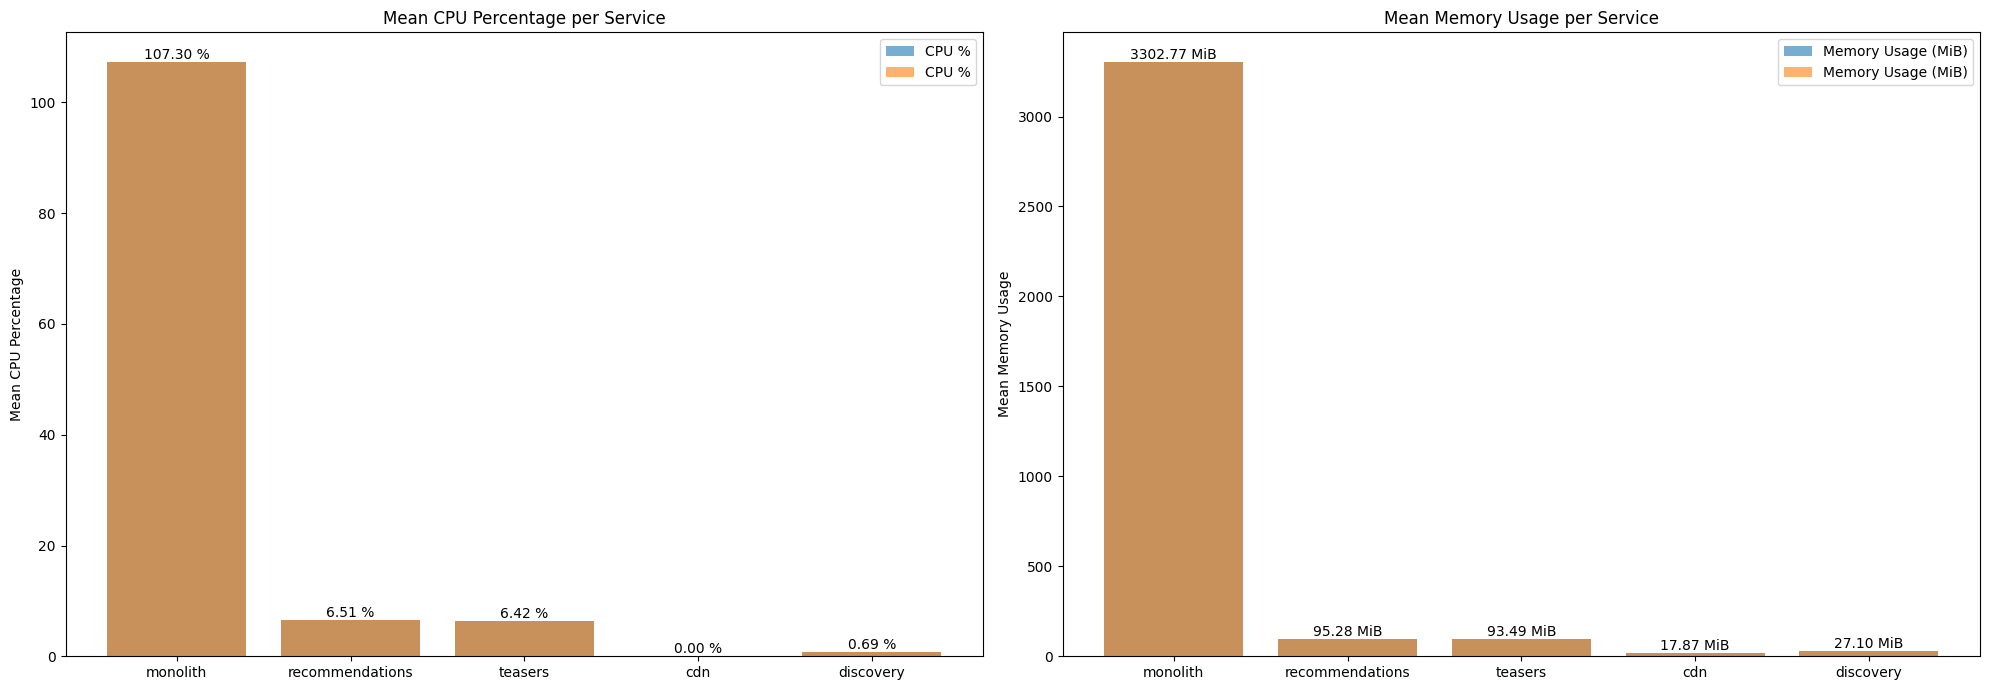

In [87]:
# Calculate mean values for CPU percentage and memory usage
mean_values = {service: {'cpu_percent': dirty_dfs[service]['cpu_percent'].mean(), 'mem_usage': dirty_dfs[service]['mem_usage'].mean()} for service in services}

# Plotting bar charts for mean CPU percentage and memory usage per service
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Mean CPU percentage per service
cpu_means = [mean_values[s]['cpu_percent'] for s in services]
bars_cpu = axes[0].bar(services, cpu_means, label='CPU %', alpha=0.6)
axes[0].bar(services, cpu_means, label='CPU %', alpha=0.6)
axes[0].set_title('Mean CPU Percentage per Service')
axes[0].set_ylabel('Mean CPU Percentage')
axes[0].legend()

for bar in bars_cpu:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f} %', ha='center', va='bottom')


# Mean memory usage per service
mem_means = [mean_values[s]['mem_usage'] for s in services]
bars_mem = axes[1].bar(services, mem_means, label='Memory Usage (MiB)', alpha=0.6)
axes[1].bar(services, mem_means, label='Memory Usage (MiB)', alpha=0.6)
axes[1].set_title('Mean Memory Usage per Service')
axes[1].set_ylabel('Mean Memory Usage')
axes[1].legend()

for bar in bars_mem:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f} MiB', ha='center', va='bottom')

plt.tight_layout()
plt.show()